In [1]:
import numpy as np
import matplotlib.pyplot as plt

import bk.load
import bk.compute
import bk.plot

import neuroseries as nts
import sklearn
from scipy.stats import zscore

In [2]:
import matplotlib as mpl

# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams["svg.fonttype"] = "none"
# %matplotlib qt


In [3]:
# PCA Functions
def pcacov(C):
    return np.linalg.eig(C)

def PlotProjections(PCScores,c=[]):

    if not len(c): c = range(np.size(PCScores,0))
    
    plt.figure()
    plt.hsv()
    plt.scatter(PCScores[:,0],PCScores[:,1],1,c = c )
    plt.colorbar()

def PCAnimation(PCScores,c=[],step=500):
    if not len(c): c = range(np.size(PCScores,0))
        
    for i in np.arange(1,np.size(PCScores)-step,5):
        plt.clf()
        plt.scatter(PCScores[i:i+step,0],PCScores[i:i+step,1],1,c = c[i:i+step] )
        plt.draw
        plt.pause(0.0000001)

def PlotProjections3D(PCScores,c=0,step=20):
    if c == 0:
        s = np.size(PCScores,0)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection = '3d')
    ax.scatter(PCScores[0:s:step,0],PCScores[0:s:step,1],PCScores[0:s:step,2],s=1,c=range(s)[0:s:step])

def IsoPlot(X,step,pos = [],sig = 5):
    iso = Isomap(n_components=2)
    Y = iso.fit_transform(X[0:-1:step,:])

    if not len(pos): 
        c = range(len(Y))
    else:
        c = pos[0:-1:step]
    Y[:,0] = gaussian_filter(Y[:,0],sig)
    Y[:,1] = gaussian_filter(Y[:,1],sig)
    plt.figure()
    plt.scatter(Y[:,0],Y[:,1],c=c)

In [19]:
actMatrix = {}
for s in np.unique(metadata['Region']):
    actMatrix.update({s:bk.compute.binSpikes(neurons[(metadata['Region'] == s) & (metadata['Type']== 'Pyr')])})

In [41]:
plt.imshow(scipy.stats.zscore(actMatrix['BLA'][1],1),aspect='auto')
plt.clim(-1,1)
plt.show()

In [34]:
%matplotlib qt

In [43]:
c = np.corrcoef(actMatrix['BLA'][1])

In [46]:
plt.imshow(c)
plt.clim(-0.04,0.04)

In [74]:
eigvalues,vectors = np.linalg.eig(c)
order = np.argsort(eigvalues)[::-1]
eigvalues = eigvalues[order]
vectors = vectors[:,order]

In [77]:
a = np.array([[1,2,3],[4,5,6]])

In [82]:
a.shape

(2, 3)

In [81]:
for i,j in enumerate(a):
    print(j)

[1 2 3]
[4 5 6]


In [49]:
w1 = vectors[:,0]
w2 = vectors[:,1]
w3 = vectors[:,2]

plt.figure()
plt.stem(range(len(w1)),w1,'b')
plt.stem(range(len(w1)),w2,'r')
plt.stem(range(len(w1)),w3,'g')

<StemContainer object of 3 artists>

In [85]:
actMatrix['BLA'][1].shape

(83, 907198)

In [57]:
p1 = zscore(actMatrix['BLA'][1].T).dot(w1)

In [135]:
t,p = dimreduction(neurons[(metadata['Region'] == 'BLA') & (metadata['Type'] == 'Pyr')])
for i in range(2):
    sm = bk.compute.nts_smooth(s,1000,250)
    s = nts.Tsd(t,p[i],time_units='s')
    plt.plot(sm.as_units('s'))
bk.plot.intervals(states['Rem'])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import bk.load
import bk.compute
import bk.plot

import neuroseries as nts
import sklearn
from scipy.stats import zscore
import scipy.signal

import seaborn as sns


In [17]:
def dimreduction(neurons,binSize = 0.025,baseline_intervals = None,as_tsd = False):
    from scipy.stats import zscore

    t,actmat = bk.compute.binSpikes(neurons,binSize=binSize)
    actmat = zscore(actmat,1)
    actmat = actmat.T
    actmat = nts.TsdFrame(t,actmat,time_units='s')

    if baseline_intervals is not None:
        c = np.corrcoef(actmat.restrict(baseline_intervals).values.T)
    else: 
        c = np.corrcoef(actmat.values.T)
    eigvalues,vectors = np.linalg.eig(c)

    #The documentation of numpy precise that eigvalues are not sorted.
    order = np.argsort(eigvalues)[::-1]
    eigvalues = eigvalues[order]
    vectors = vectors[:,order]


    fig,ax = plt.subplots(1,2)
    ax[0].bar(np.arange(0,len(eigvalues)),eigvalues/np.sum(eigvalues))
    ax[1].hist(eigvalues,25)

    
    projections = np.zeros_like(actmat.values.T)
    print(vectors.shape)
    for i,v in enumerate(vectors.T):
        projections[i] = actmat.values.dot(v)
    
    if as_tsd:
        return vectors,t,nts.TsdFrame(t,projections.T,'s')
    return vectors,t,projections.T

In [18]:
def main(path,args):

    bk.load.current_session_linux(local_path=path)
    neurons,metadata = bk.load.spikes()
    states = bk.load.states()

    t,p = dimreduction(neurons[(metadata['Region'] == 'BLA') & (metadata['Type'] == 'Pyr')],baseline_intervals=states['Rem'])
    
    times = nts.Ts(t,time_units = 's')

    is_rem = states['Rem'].in_interval(times)
    plt.figure(dpi = 96)

    for i in range(3):
        s = nts.Tsd(t,p[i],time_units='s')
        sm = bk.compute.nts_smooth(s,1000,250)
        plt.plot(sm.as_units('s'))


    # is_rem = states['Rem'].in_interval(sm.index.value)
    # print(is_rem)
    s = nts.TsdFrame(t,p.T,time_units='s')
    s = s.restrict(states['Rem'])

    is_rem = states['Rem'].in_interval(s)

    plt.plot(s)    
    sns.scatterplot(x = s[:,0].values,y=s[:,1].values)
    bk.plot.intervals(states['Rem'])
    bk.plot.intervals(states['sws'],col = 'grey')
    plt.title(bk.load.session)

In [19]:
bk.load.current_session_linux()
neurons, metadata = bk.load.spikes()
states = bk.load.states()
states.update({'sleep':states['sws'].union(states['Rem'])})

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [20]:
%matplotlib qt

In [40]:
w_bla,t_bla,p_bla = dimreduction(neurons[metadata.Region=='BLA'],1,baseline_intervals=states['sleep'],as_tsd = True)
# w_hpc,t_hpc,p_hpc = dimreduction(neurons[metadata.Region=='Hpc'],baseline_intervals=states['sleep'],as_tsd = True)

(94, 94)


In [41]:
p_bla_smooth  = bk.compute.nts_smooth(p_bla,1000,1)

In [42]:
t = p_bla_smooth.restrict(states['sleep']).index.values

fig,ax = plt.subplots(1,1,True)
ax.plot(t,p_bla_smooth.restrict(states['sleep']).values[:,0],alpha = 0.9)
ax.plot(t,p_bla_smooth.restrict(states['sleep']).values[:,1],alpha = 0.9)

bk.plot.intervals(states['Rem'],time_units='us')

/tmp/ipykernel_1008676/3593905249.py:3: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(1,1,True)


In [54]:
plt.stem(w_bla[:,0],linefmt= 'b')
plt.stem(w_bla[:,1],linefmt= 'r')

<StemContainer object of 3 artists>

In [92]:
p_bla.values.shape

(907199, 94)

In [63]:
%matplotlib

bk.load.current_session_linux(local_path='Rat08/Rat08-20130713')
neurons,metadata = bk.load.spikes()
states = bk.load.states()

t,p = dimreduction(neurons[(metadata['Region'] == 'BLA') & (metadata['Type'] == 'Pyr')],baseline_intervals=states['Rem'])

times = nts.Ts(t,time_units = 's')

is_rem = states['Rem'].in_interval(times)
plt.figure(dpi = 96)

# for i in range(3):
#     s = nts.Tsd(t,p[i],time_units='s')
#     sm = bk.compute.nts_smooth(s,1000,250)
#     plt.plot(sm.as_units('s'))

# is_rem = states['Rem'].in_interval(sm.index.value)
# print(is_rem)
s = nts.TsdFrame(t,p.T,time_units='s')
s = s.restrict(states['Rem'])

is_rem = states['Rem'].in_interval(s)

df  = pd.DataFrame(np.array([s.index.values,s[0],s[1],is_rem]).T,columns=['t','PC1','PC2','Rem'])
df['Rem'] = is_rem.astype(np.string_)
sns.scatterplot(x = 'PC1',y = 'PC2',data = df,hue = 'Rem')
# bk.plot.intervals(states['Rem'])
# bk.plot.intervals(states['sws'],col = 'grey')
plt.title(bk.load.session)

Using matplotlib backend: Qt5Agg
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


Text(0.5, 1.0, 'Rat08-20130713')

In [61]:
df['Rem']

0        [ 0.  0.  0. ... 29. 29. 29.]
1        [ 0.  0.  0. ... 29. 29. 29.]
2        [ 0.  0.  0. ... 29. 29. 29.]
3        [ 0.  0.  0. ... 29. 29. 29.]
4        [ 0.  0.  0. ... 29. 29. 29.]
                     ...              
94835    [ 0.  0.  0. ... 29. 29. 29.]
94836    [ 0.  0.  0. ... 29. 29. 29.]
94837    [ 0.  0.  0. ... 29. 29. 29.]
94838    [ 0.  0.  0. ... 29. 29. 29.]
94839    [ 0.  0.  0. ... 29. 29. 29.]
Name: Rem, Length: 94840, dtype: object

In [49]:
%matplotlib qt
plt.plot(s[0])

In [69]:
bk.load.current_session_linux()
lfp = bk.load.lfp(23,0,500)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


In [71]:
nts.FrameViewer(lfp)

AttributeError: module 'neuroseries' has no attribute 'FrameViewer'

100%|██████████| 61/61 [02:42<00:00,  2.67s/it]


Batch finished in 163.05563139915466
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


{'Rat08-20130708': None,
 'Rat08-20130709': None,
 'Rat08-20130710': None,
 'Rat08-20130711': None,
 'Rat08-20130712': None,
 'Rat08-20130713': None,
 'Rat08-20130715': None,
 'Rat08-20130716': None,
 'Rat08-20130717': None,
 'Rat09-20140324': None,
 'Rat09-20140325': None,
 'Rat09-20140326': None,
 'Rat09-20140327': None,
 'Rat09-20140328': None,
 'Rat09-20140329': None,
 'Rat09-20140331': None,
 'Rat09-20140401': None,
 'Rat09-20140402': None,
 'Rat09-20140403': None,
 'Rat10-20140619': None,
 'Rat10-20140620': None,
 'Rat10-20140622': None,
 'Rat10-20140624': None,
 'Rat10-20140626': None,
 'Rat10-20140627': None,
 'Rat10-20140628': None,
 'Rat10-20140629': None,
 'Rat10-20140701': None,
 'Rat10-20140702': None,
 'Rat10-20140703': None,
 'Rat10-20140704': None,
 'Rat11-20150321': None,
 'Rat11-20150323': None,
 'Rat11-20150325': None,
 'Rat11-20150326': None,
 'Rat11-20150327': None,
 'Rat11-20150328': None,
 'Rat11-20150330': None,
 'Rat11-20150331': None}

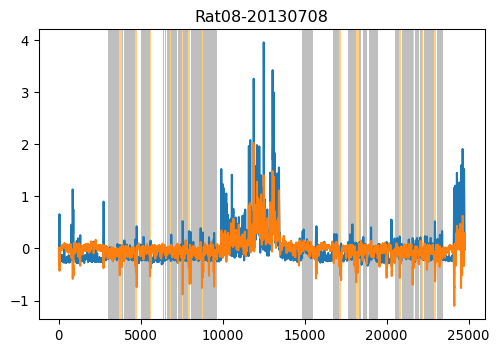

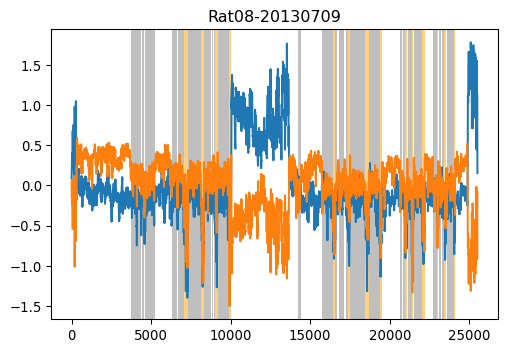

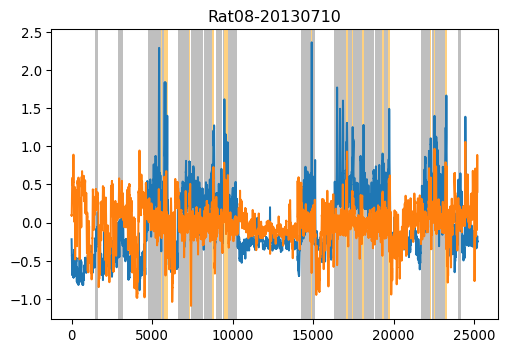

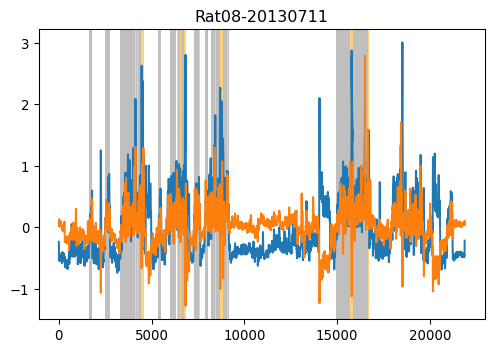

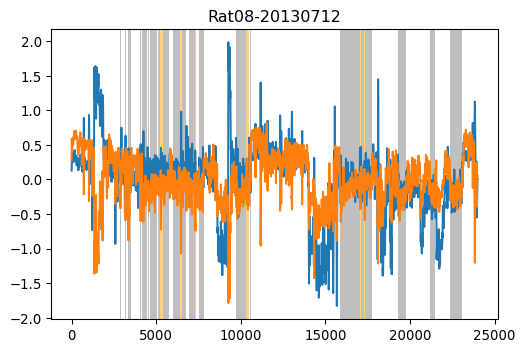

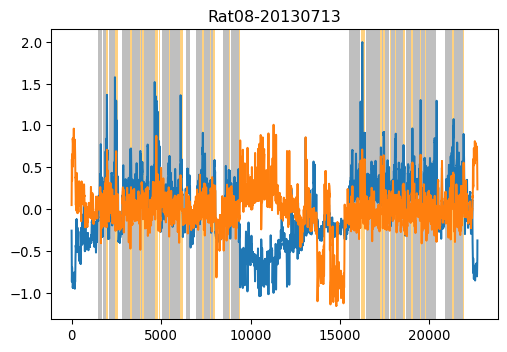

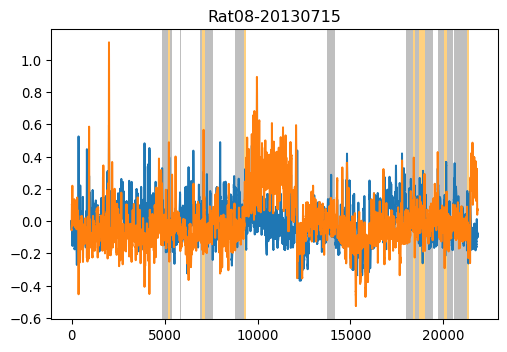

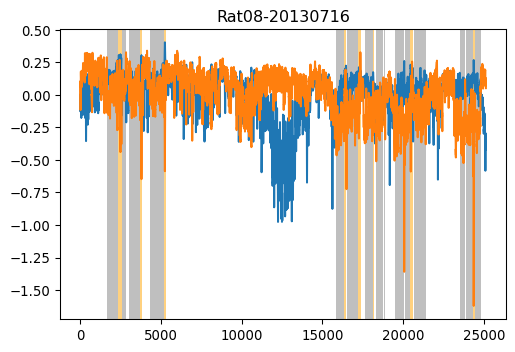

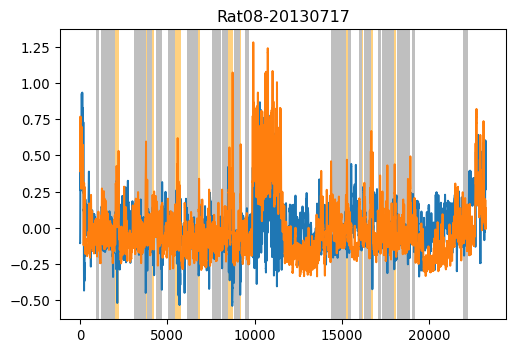

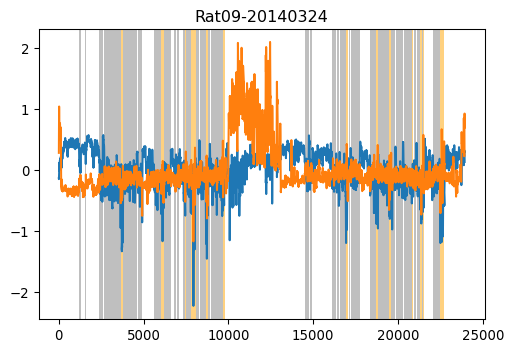

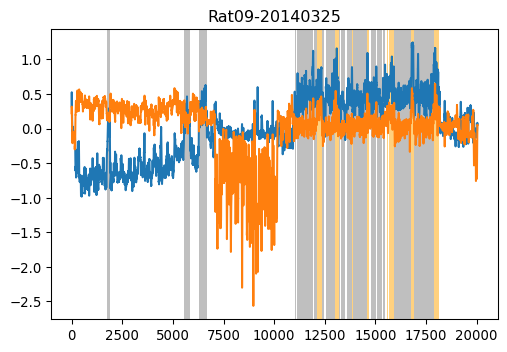

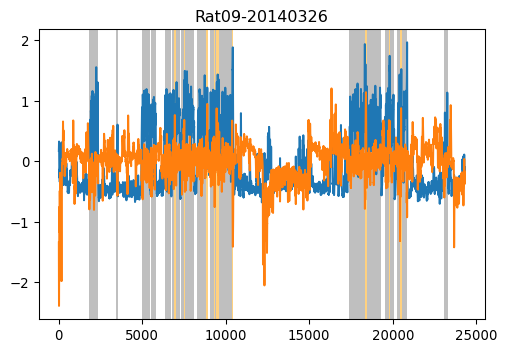

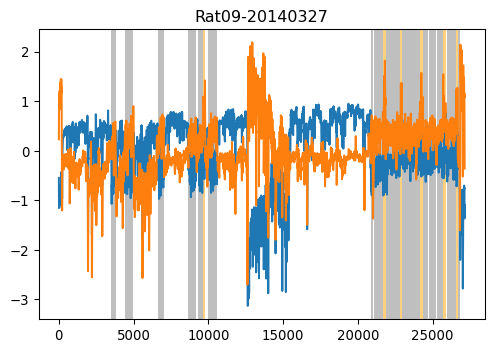

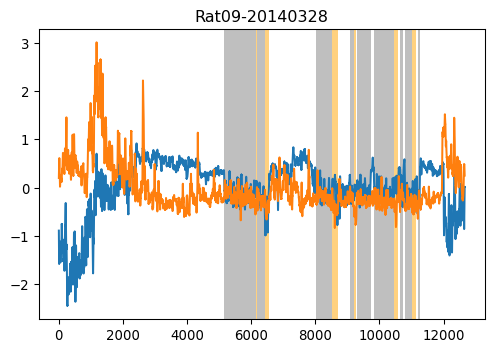

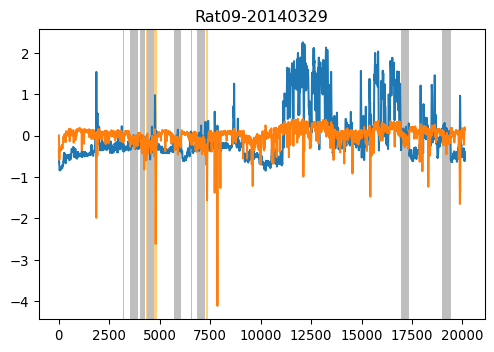

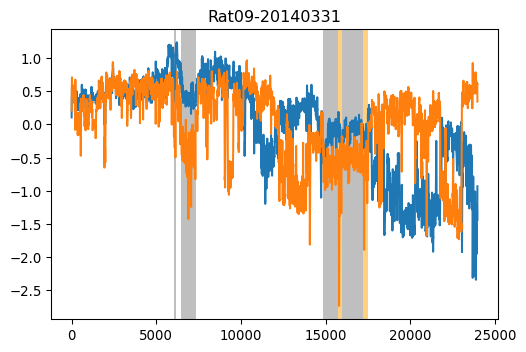

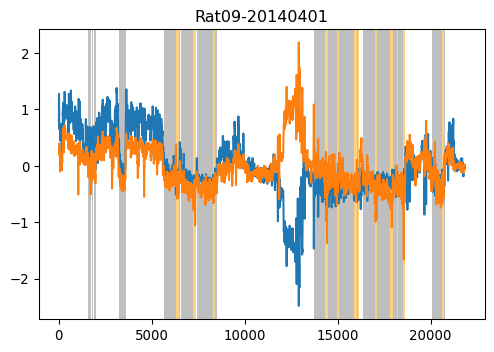

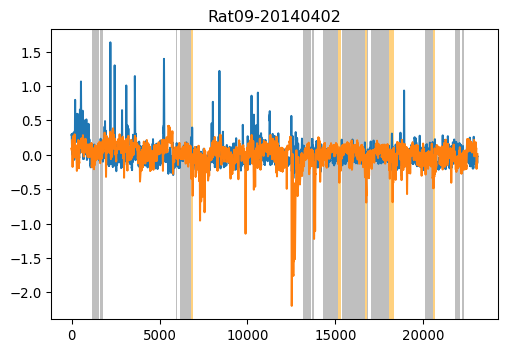

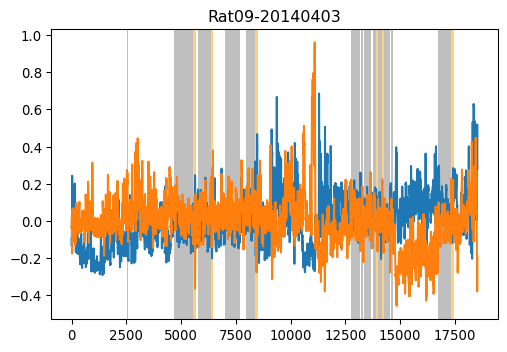

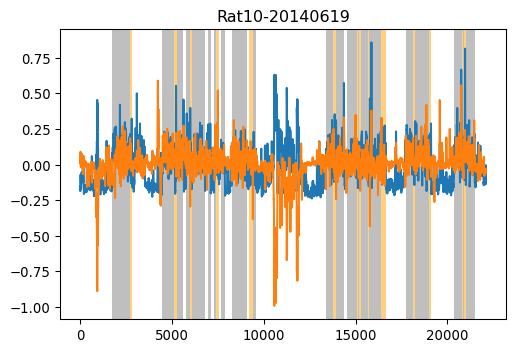

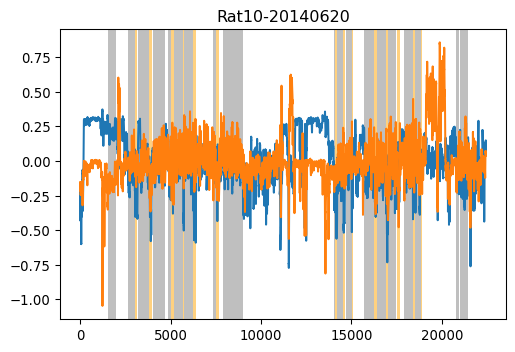

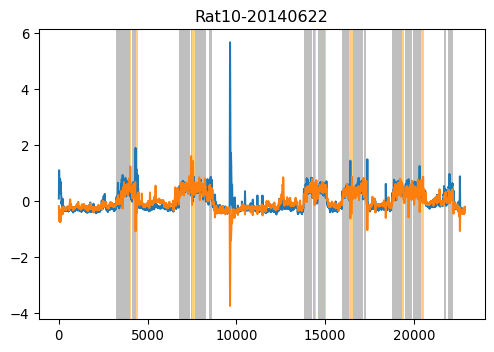

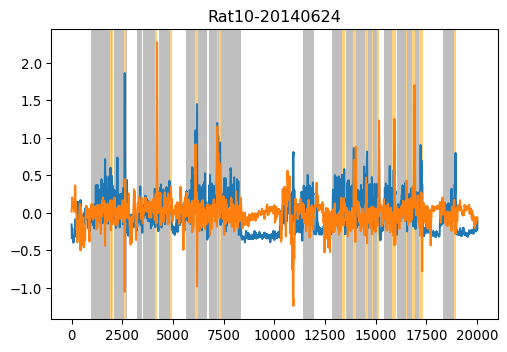

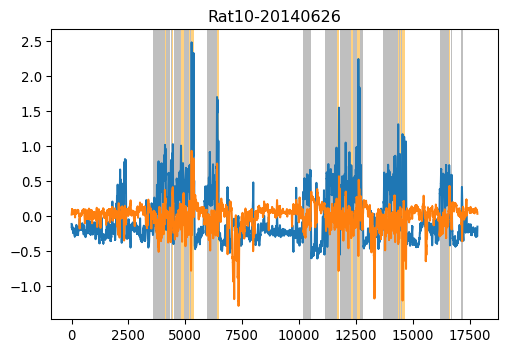

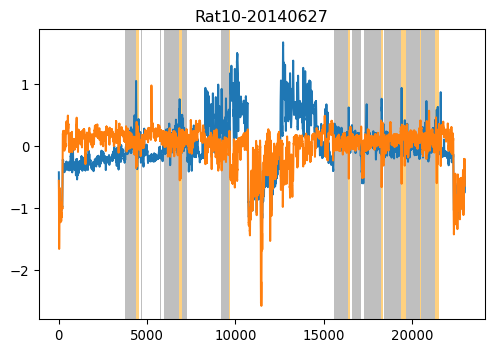

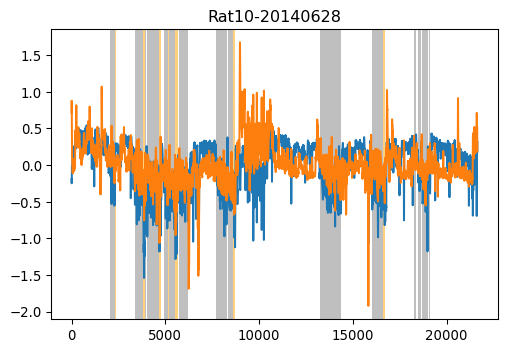

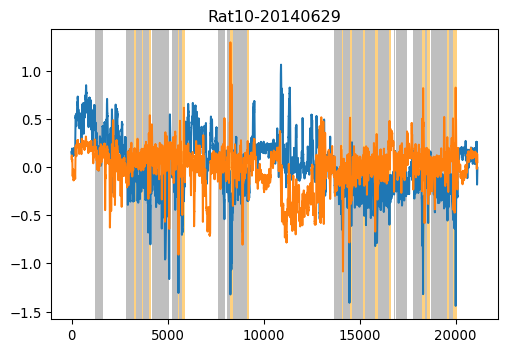

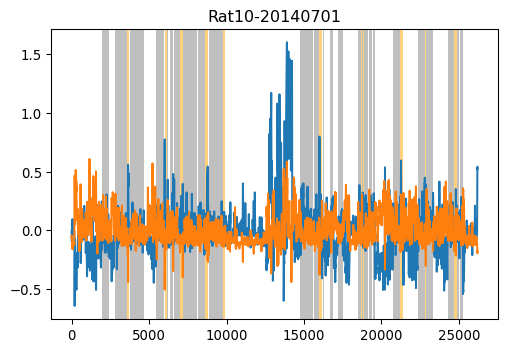

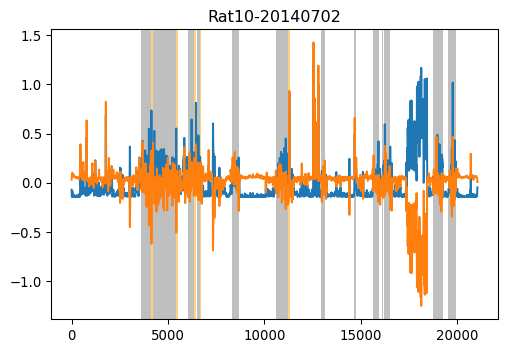

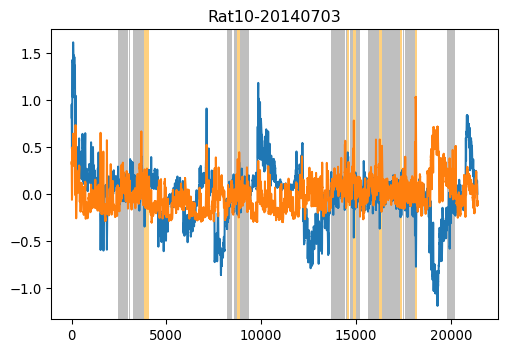

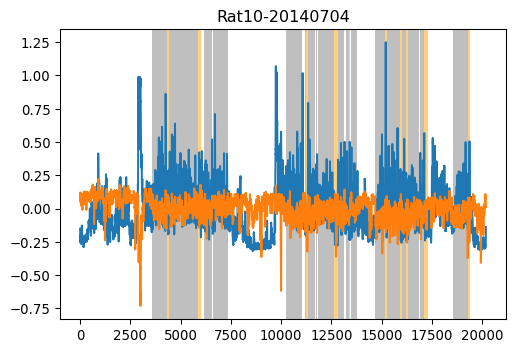

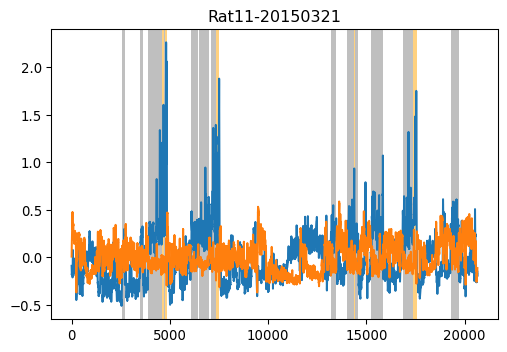

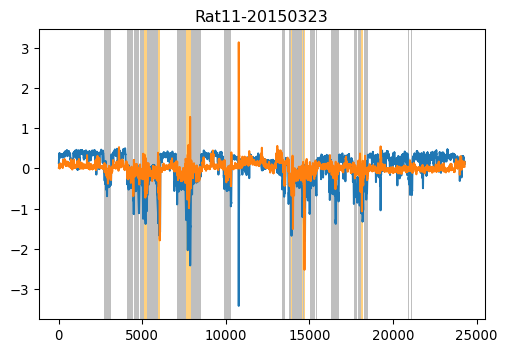

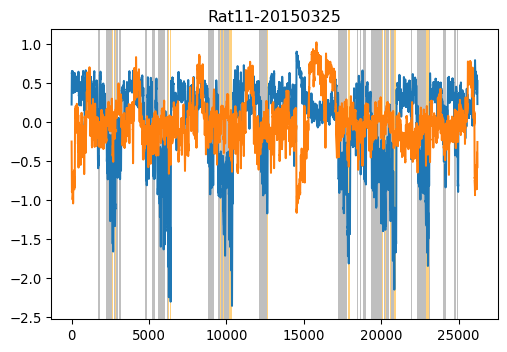

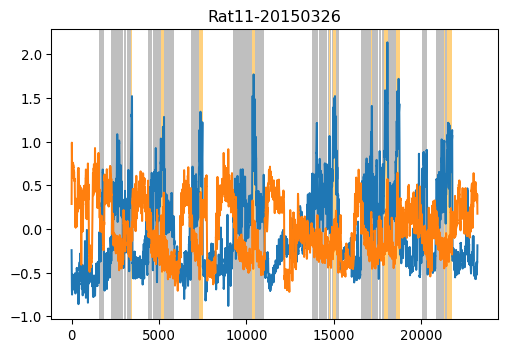

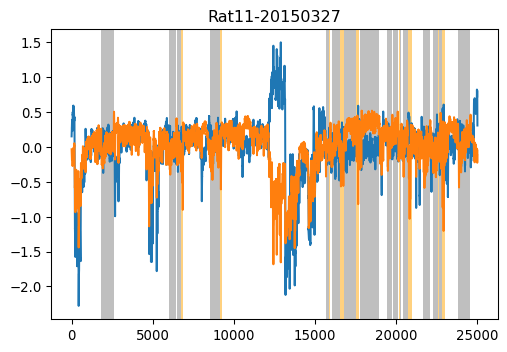

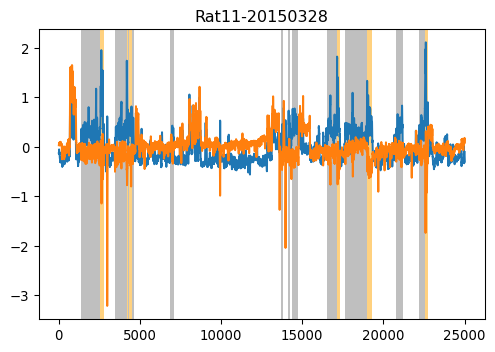

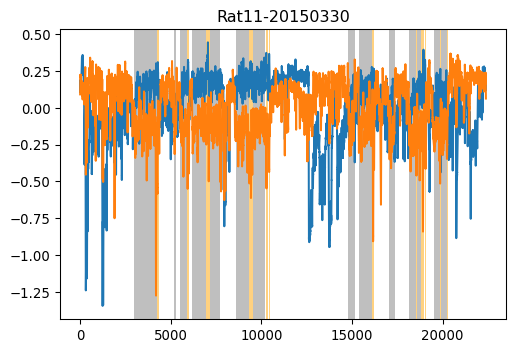

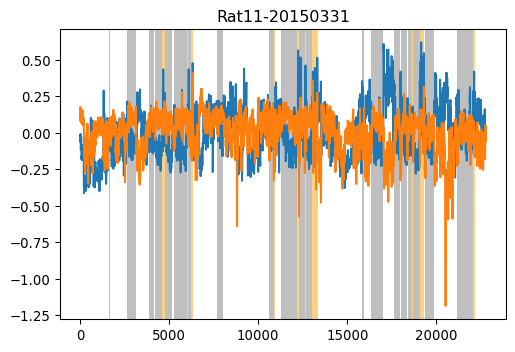

In [12]:
bk.load.batch(main,[],linux=True)